# XAI MODEL BUILD FOR XGB

In [5]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import seaborn as sns

from sklearn.model_selection import train_test_split

## Load Train and Test Datasets

In [6]:
df_train = pd.read_csv('../../../2_Modeling-Phase/train_and_test_datasets/NSL-KDD/train.csv')
df_test = pd.read_csv('../../../2_Modeling-Phase/train_and_test_datasets/NSL-KDD/test.csv')

In [7]:
X_train = df_train.drop(['binary_attack'], axis=1)  # Features
y_train = df_train['binary_attack']  # Target variable

In [8]:
X_test = df_test.drop(['binary_attack'], axis=1)  # Features
y_test = df_test['binary_attack']  # Target variable

## Load Model

In [9]:
# Load the trained model to a specific folder
model_folder = "../../../3_Post-Modeling-Phase/Trained_ML_models/Models-NSL-KDD/"
model_filename = "NSL-KDD_XGBoost.joblib"
model_path = model_folder + model_filename

model = joblib.load(model_path)

## Feature Importance

In [10]:
feature_names = df_train.columns
feature_names = feature_names[:-1]

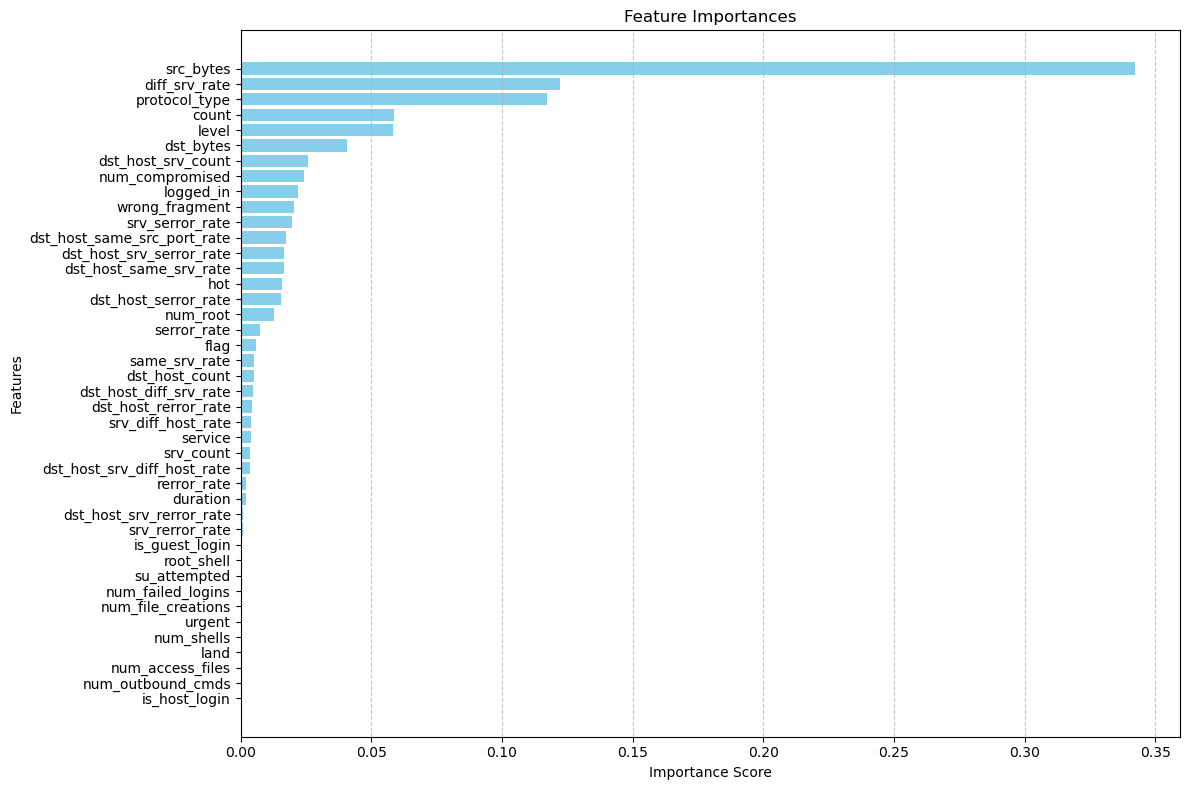

In [11]:

importances = model.feature_importances_


indices = np.argsort(importances)[::-1]


fig, ax = plt.subplots(figsize=(12, 8))

ax.barh(range(X_train.shape[1]), importances[indices], color="skyblue")

ax.set_yticks(range(X_train.shape[1]))
ax.set_yticklabels(feature_names[indices])

ax.set_title("Feature Importances")
ax.set_xlabel("Importance Score")
ax.set_ylabel("Features")

ax.invert_yaxis()

ax.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()

plt.show()

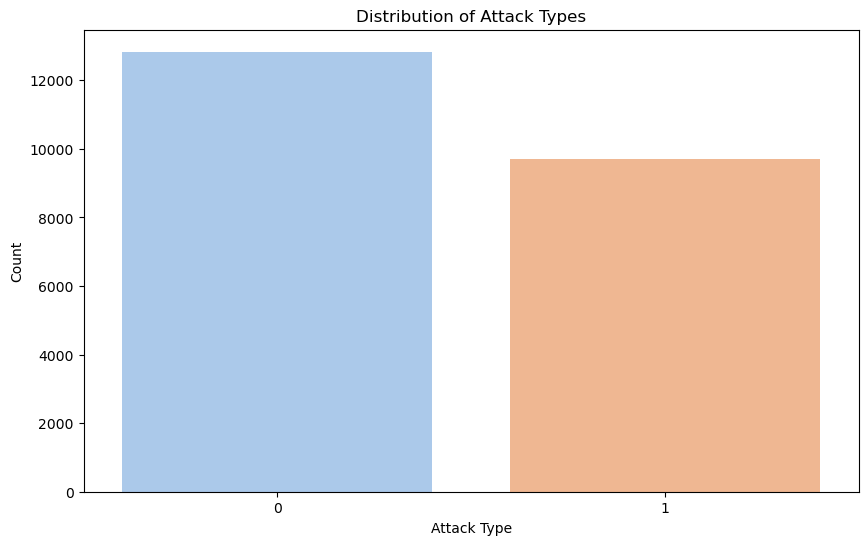

In [12]:
# Create the countplot
plt.figure(figsize=(10, 6))
sns.countplot(x=y_test, palette="pastel")

# Add labels and title
plt.xlabel("Attack Type")
plt.ylabel("Count")
plt.title("Distribution of Attack Types")

# Show the plot
plt.show()

## INTERPRET NSL-KDD MODELS

In [13]:
def calculate_feature_importance(model, feature_names):
    """
    Calculate feature importance using Gini index.

    Returns:
    - DataFrame: DataFrame containing feature names and their corresponding Gini importance.
    """
    # Create DataFrame to hold feature names
    dfp_importance = pd.DataFrame({'feat_names': feature_names})
    dfp_importance['feature'] = dfp_importance.index.astype(str)  

    # Create DataFrame to hold Gini importance
    dfp_importance_gini = pd.DataFrame({'importance_gini': model.feature_importances_})
    dfp_importance_gini['feature'] = dfp_importance_gini.index.astype(str)  

    # Calculate percentile rank of Gini importance
    dfp_importance_gini['importance_gini_pct'] = dfp_importance_gini['importance_gini'].rank(pct=True)

    # Merge DataFrames and sort by importance
    dfp_importance = pd.merge(dfp_importance, dfp_importance_gini, on='feature', how='left')
    dfp_importance = dfp_importance.sort_values(by=['importance_gini', 'feature'], ascending=[False, True]).reset_index(drop=True)
    
    return dfp_importance

%time importance_table = calculate_feature_importance(model, feature_names)
importance_table

CPU times: user 8.32 ms, sys: 2.34 ms, total: 10.7 ms
Wall time: 8.18 ms


feat_names feature  importance_gini  importance_gini_pct
0                     src_bytes       4         0.342388             1.000000
1                 diff_srv_rate      29         0.122204             0.976190
2                 protocol_type       1         0.117225             0.952381
3                         count      22         0.058834             0.928571
4                         level      41         0.058354             0.904762
5                     dst_bytes       5         0.040676             0.880952
6            dst_host_srv_count      32         0.025645             0.857143
7               num_compromised      12         0.024098             0.833333
8                     logged_in      11         0.021875             0.809524
9                wrong_fragment       7         0.020307             0.785714
10              srv_serror_rate      25         0.019700             0.761905
11  dst_host_same_src_port_rate      35         0.017524             0.738095
12     dst_host_srv_serror_rate      38         0.016524             0.714286
13       dst_host_same_srv_rate      33         0.016510             0.690476
14                          hot       9         0.015688             0.666667
15         dst_host_serror_rate      37         0.015449             0.642857
16                     num_root      15         0.012572             0.619048
17                  serror_rate      24         0.007349             0.595238
18                         flag       3         0.006004             0.571429
19                same_srv_rate      28         0.005112             0.547619
20               dst_host_count      31         0.005074             0.523810
21       dst_host_diff_srv_rate      34         0.004638             0.500000
22         dst_host_rerror_rate      39         0.004533             0.476190
23           srv_diff_host_rate      30         0.004015             0.452381
24                      service       2         0.003775             0.428571
25                    srv_count      23         0.003758             0.404762
26  dst_host_srv_diff_host_rate      36         0.003640             0.380952
27                  rerror_rate      26         0.002220             0.357143
28                     duration       0         0.002113             0.333333
29     dst_host_srv_rerror_rate      40         0.000988             0.309524
30              srv_rerror_rate      27         0.000759             0.285714
31               is_guest_login      21         0.000451             0.261905
32            num_failed_logins      10         0.000000             0.130952
33                   root_shell      13         0.000000             0.130952
34                 su_attempted      14         0.000000             0.130952
35           num_file_creations      16         0.000000             0.130952
36                   num_shells      17         0.000000             0.130952
37             num_access_files      18         0.000000             0.130952
38            num_outbound_cmds      19         0.000000             0.130952
39                is_host_login      20         0.000000             0.130952
40                         land       6         0.000000             0.130952
41                       urgent       8         0.000000             0.130952

## Morris Sensitivity Analysis

In [14]:
from interpret.blackbox import MorrisSensitivity
from sklearn.pipeline import Pipeline
from interpret import show

%time msa = MorrisSensitivity(model, X_test, feature_names=feature_names)

explanation = msa.explain_global()

# Extracting the Morris sensitivity results as a DataFrame
sensitivity_df = pd.DataFrame(explanation.data()["scores"], index=feature_names)
sorted_sensitivity_df = sensitivity_df.sort_values(by=sensitivity_df.columns[0], ascending=False)
print(sorted_sensitivity_df)

show(explanation, max_features=len(feature_names))

CPU times: user 5.51 s, sys: 117 ms, total: 5.63 s
Wall time: 828 ms
                                    0
protocol_type                0.317634
level                        0.236586
dst_host_rerror_rate         0.205083
dst_host_srv_serror_rate     0.181035
dst_host_same_srv_rate       0.127988
src_bytes                    0.103357
service                      0.072003
dst_host_srv_count           0.068724
dst_host_srv_rerror_rate     0.066514
dst_host_serror_rate         0.064372
dst_host_same_src_port_rate  0.053949
dst_host_diff_srv_rate       0.049165
dst_host_count               0.048380
flag                         0.046075
serror_rate                  0.045491
wrong_fragment               0.045002
srv_count                    0.044761
count                        0.040342
dst_bytes                    0.039238
hot                          0.038482
duration                     0.035147
same_srv_rate                0.032783
srv_serror_rate              0.023462
diff_srv_rate      

<!-- http://127.0.0.1:7257/5658422736/ -->

## LOFO IMPORTANCE

[LightGBM] [Info] Number of positive: 7313, number of negative: 9595
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001884 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2952
[LightGBM] [Info] Number of data points in the train set: 16908, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432517 -> initscore=-0.271589
[LightGBM] [Info] Start training from score -0.271589
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 7267, number of negative: 9641
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001120 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2952
[LightGBM] [Info] Number of data points 

  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7313, number of negative: 9595
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001255 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2718
[LightGBM] [Info] Number of data points in the train set: 16908, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432517 -> initscore=-0.271589
[LightGBM] [Info] Start training from score -0.271589
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 7267, number of negative: 9641
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000940 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2716
[LightGBM] [Info] Number of data points 

[LightGBM] [Info] Number of positive: 7293, number of negative: 9615
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000878 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2895
[LightGBM] [Info] Number of data points in the train set: 16908, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.431334 -> initscore=-0.276409
[LightGBM] [Info] Start training from score -0.276409
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 7260, number of negative: 9648
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000896 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.

[LightGBM] [Info] Number of positive: 7293, number of negative: 9615
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000855 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2856
[LightGBM] [Info] Number of data points in the train set: 16908, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.431334 -> initscore=-0.276409
[LightGBM] [Info] Start training from score -0.276409
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 7260, number of negative: 9648
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000884 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.

[LightGBM] [Info] Number of positive: 7293, number of negative: 9615
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001118 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2956
[LightGBM] [Info] Number of data points in the train set: 16908, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.431334 -> initscore=-0.276409
[LightGBM] [Info] Start training from score -0.276409
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 7260, number of negative: 9648
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000902 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.

[LightGBM] [Info] Number of positive: 7313, number of negative: 9595
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002285 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2948
[LightGBM] [Info] Number of data points in the train set: 16908, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432517 -> initscore=-0.271589
[LightGBM] [Info] Start training from score -0.271589
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 7267, number of negative: 9641
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000843 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2949
[LightGBM] [Info] Number of data points in the train set: 16908, number of used features: 30
[LightGBM] 

[LightGBM] [Info] Number of positive: 7293, number of negative: 9615
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000889 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2855
[LightGBM] [Info] Number of data points in the train set: 16908, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.431334 -> initscore=-0.276409
[LightGBM] [Info] Start training from score -0.276409
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 7260, number of negative: 9648
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000848 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.

[LightGBM] [Info] Number of positive: 7293, number of negative: 9615
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000942 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2701
[LightGBM] [Info] Number of data points in the train set: 16908, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.431334 -> initscore=-0.276409
[LightGBM] [Info] Start training from score -0.276409
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 7260, number of negative: 9648
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of t

[LightGBM] [Info] Number of positive: 7260, number of negative: 9648
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001109 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2944
[LightGBM] [Info] Number of data points in the train set: 16908, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429383 -> initscore=-0.284371
[LightGBM] [Info] Start training from score -0.284371
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 7313, number of negative: 9595
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002923 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2889
[LightGBM] [Info] Number of d

[LightGBM] [Info] Number of positive: 7313, number of negative: 9595
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2907
[LightGBM] [Info] Number of data points in the train set: 16908, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432517 -> initscore=-0.271589
[LightGBM] [Info] Start training from score -0.271589
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 7267, number of negative: 9641
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000968 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2906
[LightGBM] [Info] Number of data points in the train set: 16908, number of used features: 30
[LightGBM] 

[LightGBM] [Info] Number of positive: 7313, number of negative: 9595
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001020 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2734
[LightGBM] [Info] Number of data points in the train set: 16908, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432517 -> initscore=-0.271589
[LightGBM] [Info] Start training from score -0.271589
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 7267, number of negative: 9641
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001095 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.

[LightGBM] [Info] Number of positive: 7313, number of negative: 9595
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2889
[LightGBM] [Info] Number of data points in the train set: 16908, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432517 -> initscore=-0.271589
[LightGBM] [Info] Start training from score -0.271589
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 7267, number of negative: 9641
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000889 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2889
[LightGBM] [Info] Number of data points in the train set: 16908, number of used features: 30
[LightGBM] 

[LightGBM] [Info] Number of positive: 7293, number of negative: 9615
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000977 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2956
[LightGBM] [Info] Number of data points in the train set: 16908, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.431334 -> initscore=-0.276409
[LightGBM] [Info] Start training from score -0.276409
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 7260, number of negative: 9648
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000956 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.

[LightGBM] [Info] Number of positive: 7293, number of negative: 9615
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000939 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2863
[LightGBM] [Info] Number of data points in the train set: 16908, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.431334 -> initscore=-0.276409
[LightGBM] [Info] Start training from score -0.276409
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 7260, number of negative: 9648
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001073 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.

CPU times: user 2min 7s, sys: 1.69 s, total: 2min 9s
Wall time: 22 s


feature  importance_mean  importance_std  \
21                        level     4.375031e-04        0.000130   
26  dst_host_srv_diff_host_rate     3.999792e-05        0.000064   
27     dst_host_srv_serror_rate     3.531543e-05        0.000068   
32                      service     3.048634e-05        0.000056   
5        dst_host_same_srv_rate     2.812347e-05        0.000056   
38         dst_host_serror_rate     1.775937e-05        0.000025   
18                  serror_rate     1.193215e-05        0.000027   
12           dst_host_srv_count     1.110946e-05        0.000019   
1                     logged_in     1.003662e-05        0.000023   
3                   rerror_rate     7.879319e-06        0.000022   
8                          flag     6.435550e-06        0.000014   
7               srv_serror_rate     4.571917e-06        0.000017   
28                        count     4.359947e-06        0.000026   
33     dst_host_srv_rerror_rate     4.299925e-06        0.000011   
29                    srv_count     2.287651e-06        0.000012   
41           srv_diff_host_rate     2.076728e-06        0.000016   
4                 same_srv_rate     5.533589e-07        0.000008   
9                    num_shells     0.000000e+00        0.000000   
17                   root_shell     0.000000e+00        0.000000   
15             num_access_files     0.000000e+00        0.000000   
40                         land     0.000000e+00        0.000000   
2             num_outbound_cmds     0.000000e+00        0.000000   
14                 su_attempted     0.000000e+00        0.000000   
22                     num_root     0.000000e+00        0.000000   
37           num_file_creations     0.000000e+00        0.000000   
35                is_host_login     0.000000e+00        0.000000   
34                       urgent     0.000000e+00        0.000000   
30               wrong_fragment     0.000000e+00        0.000000   
16         dst_host_rerror_rate    -1.075112e-06        0.000016   
31                diff_srv_rate    -2.559638e-06        0.000008   
11              num_compromised    -3.365743e-06        0.000005   
13            num_failed_logins    -3.750948e-06        0.000005   
20  dst_host_same_src_port_rate    -4.904429e-06        0.000004   
6        dst_host_diff_srv_rate    -7.129215e-06        0.000007   
25               is_guest_login    -7.418228e-06        0.000008   
23              srv_rerror_rate    -9.182508e-06        0.000007   
10                          hot    -1.001613e-05        0.000018   
39                     duration    -1.445847e-05        0.000023   
0                dst_host_count    -1.593092e-05        0.000024   
36                    dst_bytes    -1.767625e-05        0.000057   
24                protocol_type    -2.041224e-05        0.000017   
19                    src_bytes    -3.783463e-05        0.000060   

       val_imp_0     val_imp_1     val_imp_2  val_imp_3  
21  3.738059e-04  5.291461e-04  2.576106e-04   0.000589  
26  3.219689e-06 -8.972923e-07  1.515205e-04   0.000006  
27 -3.090902e-06  3.845539e-07  1.531912e-04  -0.000009  
32  1.957571e-05  4.358277e-06  1.232470e-04  -0.000025  
5   6.439379e-07 -6.793785e-06  1.258173e-04  -0.000007  
38  5.151503e-07 -7.691077e-07  6.053110e-05   0.000011  
18  4.121203e-06 -6.281046e-06  5.731820e-05  -0.000007  
12 -5.022716e-06  1.345938e-05  4.112516e-05  -0.000005  
1   4.378778e-06 -1.538215e-06  4.845058e-05  -0.000011  
3  -2.575752e-06  0.000000e+00  4.523768e-05  -0.000011  
8   5.280291e-06  5.127385e-07  2.891613e-05  -0.000009  
7  -2.060601e-06 -2.179139e-06  3.392826e-05  -0.000011  
28  4.468929e-05 -5.511939e-06 -2.737394e-05   0.000006  
33 -5.151503e-06 -7.178339e-06  2.056258e-05   0.000009  
29 -2.962114e-06 -3.589169e-06  2.274736e-05  -0.000007  
41  4.765140e-06 -6.024677e-06  2.685987e-05  -0.000017  
4  -9.015130e-07 -1.666400e-06  1.285161e-05  -0.000008  
9   0.000000e+00  0.000000e+00  0.000000e+00   0.000000

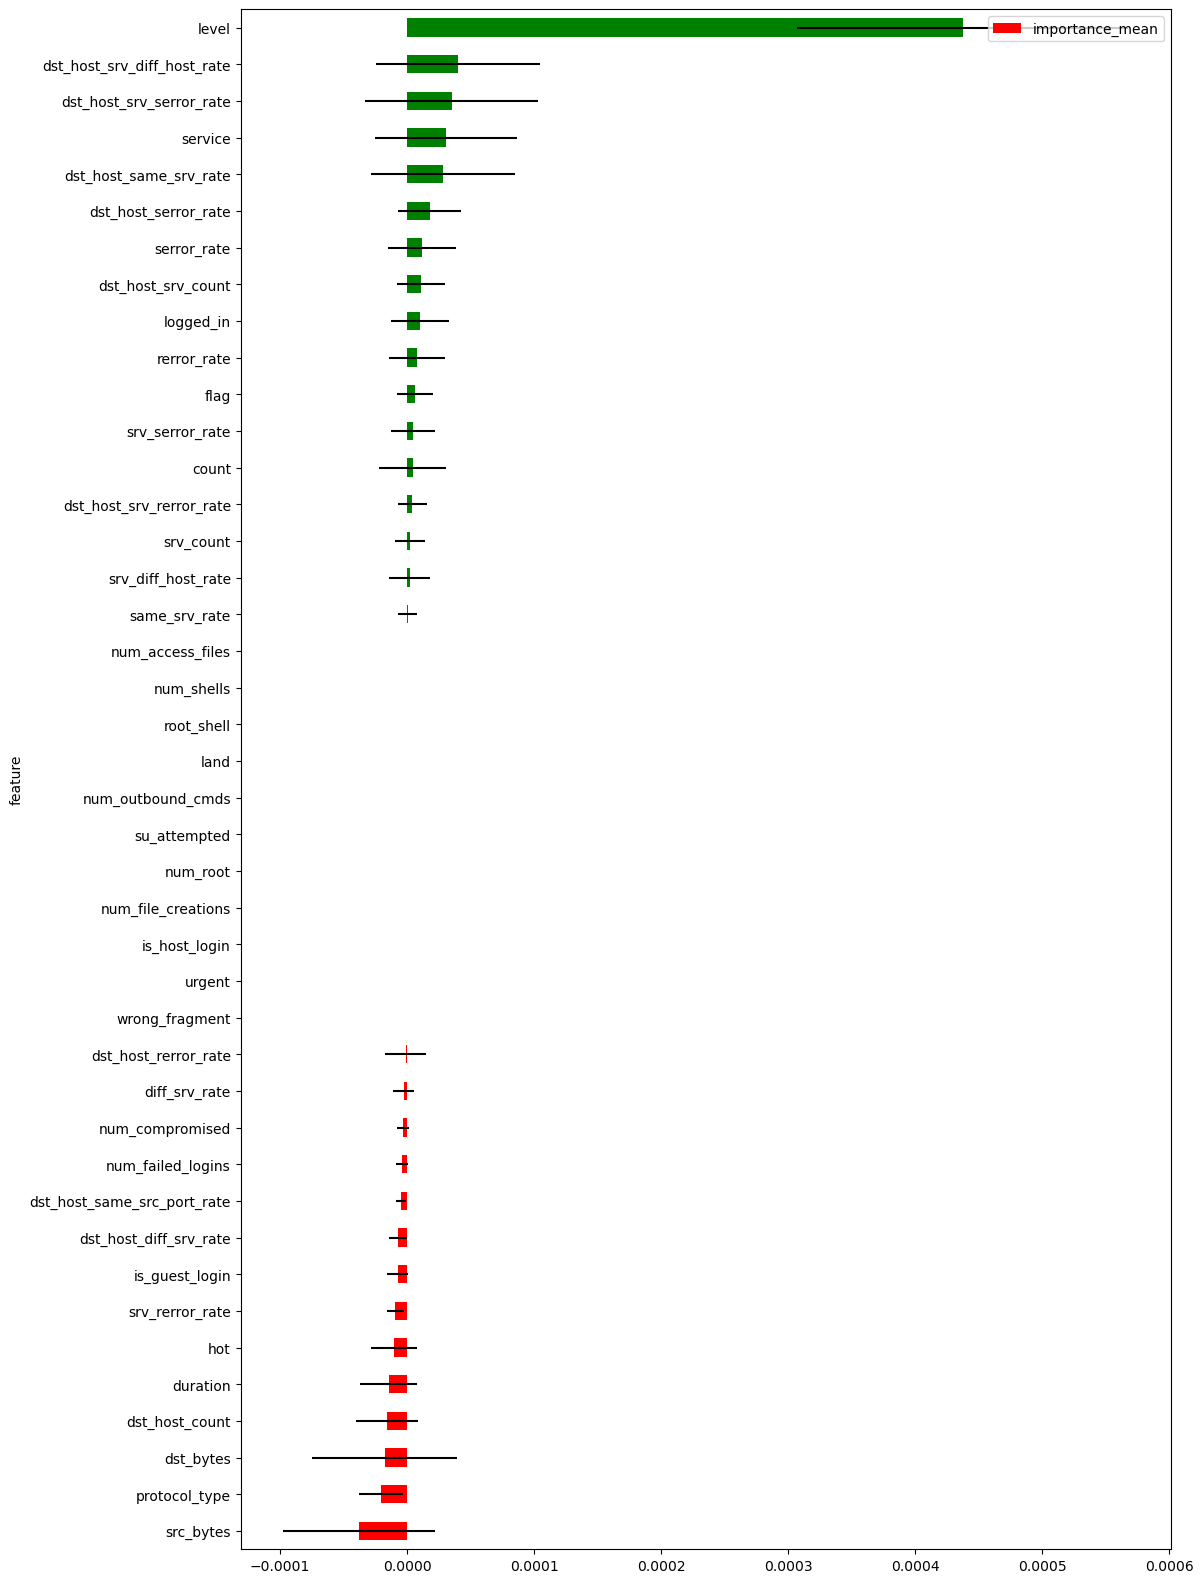

In [15]:
from lofo import LOFOImportance, Dataset, plot_importance
from sklearn.model_selection import KFold
import pandas as pd

def calculate_lofo_importance(df, target_column, feature_names, cv_splits=4, scoring="roc_auc"):
    """
    Calculate LOFO (Leave One Feature Out) importance using the specified validation scheme and scorer.
    """
    cv = KFold(n_splits=cv_splits, shuffle=False, random_state=None) # Don't shuffle to keep the time split validation

    # Define the dataset
    dataset = Dataset(df=df, target=target_column, features=feature_names)

    # Define the LOFOImportance object
    lofo_imp = LOFOImportance(dataset, cv=cv, scoring=scoring)

    # Get the mean and standard deviation of the importances in pandas format
    importance = lofo_imp.get_importance()
    
    # plot the means and standard deviations of the importances
    plot_importance(importance, figsize=(12, 20))
    
    return importance

%time importance = calculate_lofo_importance(df=df_test, target_column="binary_attack", feature_names=feature_names)

importance


## SHAP EXPLAINABILITY

100%|===================| 22514/22544 [09:15<00:00]        

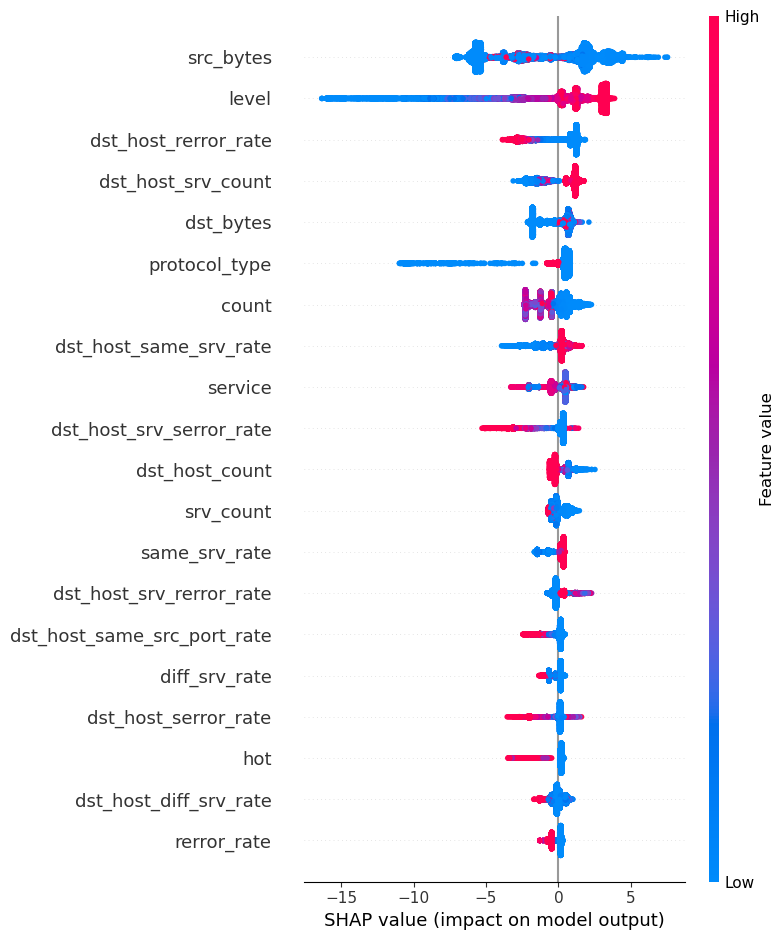

In [81]:
import shap

shap.initjs()

# Ensure X_test has column names matching X_train
X_test = pd.DataFrame(X_test, columns=X_train.columns)

# Initialize SHAP explainer
explainer = shap.Explainer(model, X_test)

# Get SHAP values
shap_values = explainer(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test)

# Force plot (for individual predictions)
# Extract the base value and SHAP values for a specific prediction
base_value = shap_values.base_values[0]  # Base value for the first prediction
shap_values_for_instance = shap_values.values[0]  # SHAP values for the first instance
features = X_test.iloc[0]  # Features for the first instance

# Create the force plot
shap.force_plot(
    base_value,
    shap_values_for_instance,
    features
)


# EVALUATION METRICS

In [62]:
import numpy as np
from scipy.stats import spearmanr

# Functions for Metrics
def calculate_local_explanation_quality(predicted_explanations, actual_model_outputs):
    """
    Calculate the Local Explanation Quality (Fidelity Local).

    Args:
        predicted_explanations (np.ndarray): Predicted explanation outputs (e.g., SHAP predicted values).
        actual_model_outputs (np.ndarray): Actual local model outputs.

    Returns:
        float: Local explanation quality score.
    """
    N = len(predicted_explanations)
    fidelity_local = 1 - (np.sum((predicted_explanations - actual_model_outputs) ** 2) / N)
    return fidelity_local

def calculate_global_explanation_utility(feature_importance_values, domain_importance_values):
    """
    Calculate the Global Explanation Utility using Spearman's Rank Correlation.

    Args:
        feature_importance_values (np.ndarray): Feature importance values (e.g., SHAP feature importance).
        domain_importance_values (np.ndarray): Domain knowledge importance values.

    Returns:
        float: Spearman's Rank Correlation.
    """
    if len(feature_importance_values) != len(domain_importance_values):
        raise ValueError("The number of domain importance scores must match the number of SHAP features.")
    correlation, _ = spearmanr(feature_importance_values, domain_importance_values)
    return correlation

## 1. SHAP Local Explanation Quality (Fidelity)

In [66]:
shap_predicted_values = shap_values.values[:, 0]  # Predicted explanation outputs for the first class

# Actual model outputs for the test set
actual_model_outputs = model.predict_proba(X_test)[:, 0]  # Predicted probabilities for the first class

# SHAP Feature Importance
shap_feature_importance = np.mean(np.abs(shap_values.values), axis=0)  # Average absolute SHAP values

# Domain Knowledge Importance Scores
# Replace with meaningful values for your domain or use uniform values for testing
domain_importance_scores = np.array([
    0.08,  # duration
    0.06,  # protocol_type
    0.04,  # service
    0.06,  # flag
    0.10,  # src_bytes (important for intrusion detection)
    0.07,  # dst_bytes
    0.02,  # land
    0.05,  # wrong_fragment
    0.02,  # urgent
    0.07,  # hot
    0.09,  # num_failed_logins (critical for detecting brute force attacks)
    0.04,  # logged_in
    0.03,  # num_compromised
    0.03,  # root_shell
    0.02,  # su_attempted
    0.02,  # num_root
    0.02,  # num_file_creations
    0.02,  # num_shells
    0.02,  # num_access_files
    0.01,  # num_outbound_cmds
    0.01,  # is_host_login
    0.05,  # is_guest_login (important for intrusion detection)
    0.07,  # count
    0.08,  # srv_count (important for DoS and DDoS detection)
    0.07,  # serror_rate (key feature for detecting SYN flood attacks)
    0.07,  # srv_serror_rate
    0.06,  # rerror_rate
    0.06,  # srv_rerror_rate
    0.08,  # same_srv_rate (important for connection-based attacks)
    0.07,  # diff_srv_rate
    0.05,  # srv_diff_host_rate
    0.04,  # dst_host_count
    0.07,  # dst_host_srv_count
    0.08,  # dst_host_same_srv_rate
    0.05,  # dst_host_diff_srv_rate
    0.04,  # dst_host_same_src_port_rate
    0.05,  # dst_host_srv_diff_host_rate
    0.06,  # dst_host_serror_rate
    0.07,  # dst_host_srv_serror_rate
    0.05,  # dst_host_rerror_rate
    0.06,  # dst_host_srv_rerror_rate
    0.04   # level
])

# Normalize to sum to 1
domain_importance_scores /= domain_importance_scores.sum()

# Ensure SHAP and domain importance lengths match
if len(shap_feature_importance) != len(domain_importance_scores):
    raise ValueError("The number of domain importance scores must match the number of SHAP features.")

# Calculate the Metrics
local_quality = calculate_local_explanation_quality(shap_predicted_values, actual_model_outputs)

# Outputs
print(f"SHAP Local Explanation Quality (Fidelity Local): {local_quality:.4f}")

SHAP Local Explanation Quality (Fidelity Local): 0.5085


## 2. SHAP Global Explanation Utility

In [67]:
global_utility = calculate_global_explanation_utility(shap_feature_importance, domain_importance_scores)

# Outputs
print(f"SHAP Global Explanation Utility (Spearman's Rank Correlation): {global_utility:.4f}")

SHAP Global Explanation Utility (Spearman's Rank Correlation): 0.5938


# LLM Explainability Of SHAP

In [37]:
import os
import openai

In [46]:
# Prepare SHAP explanation values for the first instance
shap_description_prompt = f"""
Given the following SHAP values for a machine learning model prediction:

Base Value (Average Model Output): {shap_values.base_values[0]}
SHAP Values: {shap_values.values[0]}
Feature Values: {X_test.iloc[0].to_dict()}

Explain the prediction in simple English to a network analyst.
"""

# Generate explanation using an LLM
response = openai.Completion.create(
    model="gpt-3.5-turbo-instruct",
    prompt=shap_description_prompt,
    max_tokens=400,
    temperature=0.7  # Adjust for creativity
)

print("Plain English Explanation")
print(response["choices"][0]["text"])


Plain English Explanation

Based on the SHAP values, the duration of the connection, the amount of bytes sent and received, and whether or not the login was successful did not have a significant impact on the prediction. However, the type of protocol used, the specific service being accessed, and the flag of the connection did have an impact. The destination host count and the rate of error messages also played a role in the prediction. The model predicts a high likelihood of an attack based on these factors.


# Kernal SHAP

  0%|          | 0/10 [00:00<?, ?it/s]

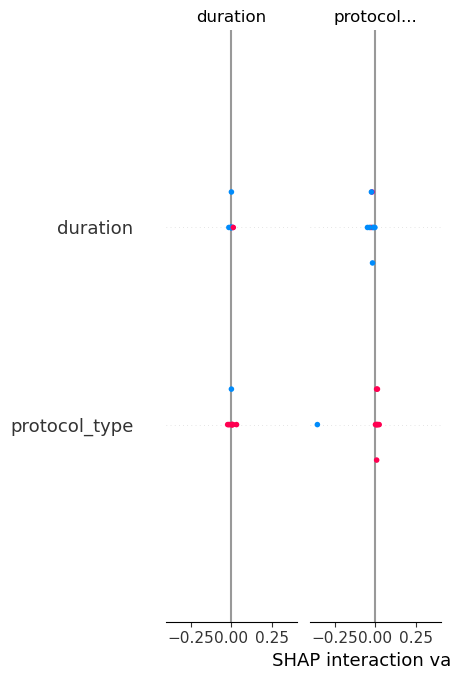

In [43]:
# Define a prediction function for Kernel SHAP
def predict_proba(X):
    X_df = pd.DataFrame(X, columns=X_train.columns)  # Ensure input has column names
    return model.predict_proba(X_df)

# Initialize Kernel SHAP explainer with a sample of the training data
kernel_explainer = shap.KernelExplainer(predict_proba, shap.sample(X_train, 100))

# Compute SHAP values for the first 10 instances of X_test
kernel_shap_values = kernel_explainer.shap_values(X_test.iloc[:10])  # Limit to 10 instances to save time

# Visualize global feature importance using a summary plot
shap.summary_plot(kernel_shap_values, X_test.iloc[:10])


# Waterfall Plot

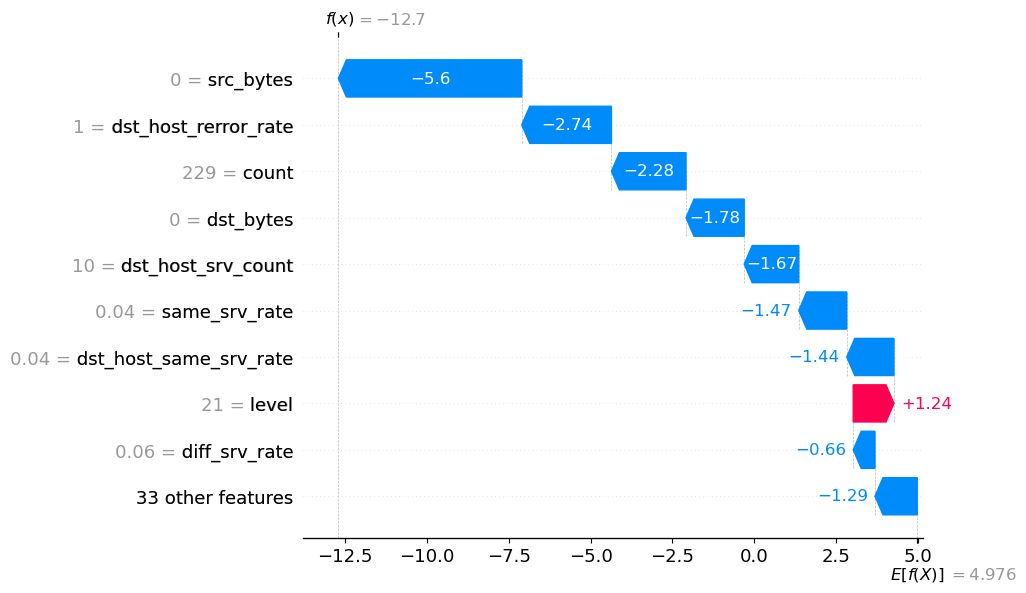

In [79]:
shap.plots.waterfall(shap_values[0])

## LIME EXPLAINABILITY

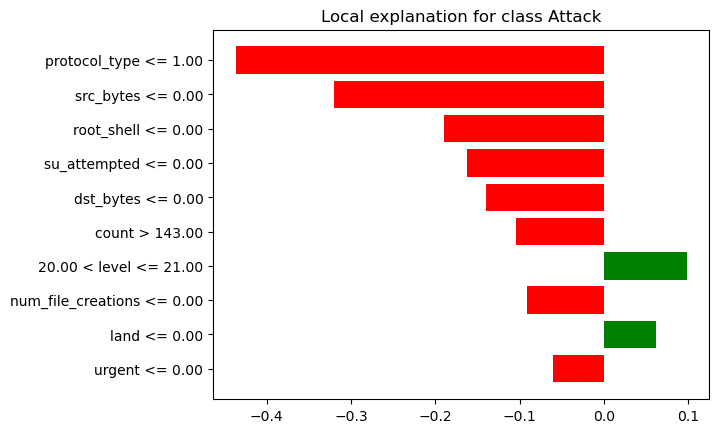

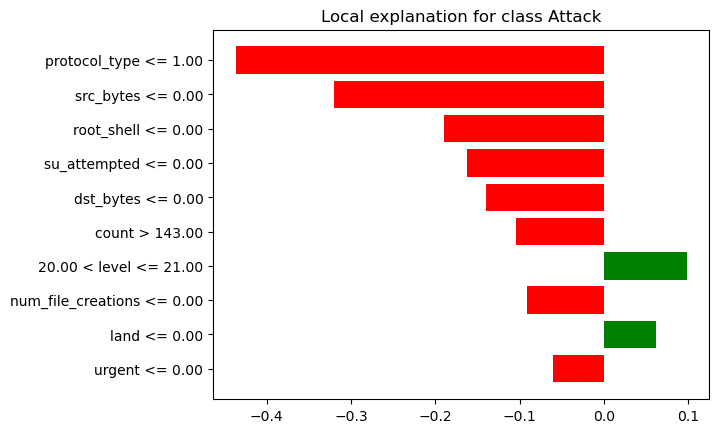

In [71]:
from lime.lime_tabular import LimeTabularExplainer
import numpy as np

lime_explainer = LimeTabularExplainer(
    training_data=np.array(X_train),  # Training data as a NumPy array
    feature_names=X_train.columns,   # Feature names
    class_names=['malicious', 'normal'],  # Replace with your model's class labels
    mode='classification'            # Use 'regression' for regression models
)

# Pick a test instance to explain
test_instance = X_test.iloc[0]

# Explain the prediction for the selected test instance
lime_explanation = lime_explainer.explain_instance(
    data_row=test_instance,         # The test instance to explain
    predict_fn=model.predict_proba  # Prediction function (returns probabilities)
)

# Show the explanation in a human-readable format
lime_explanation.show_in_notebook(show_table=True)

# Visualize LIME explanation as a chart
lime_explanation.as_pyplot_figure()


## 1. LIME Local Explanation Quality (Fidelity)

In [72]:
# Extract LIME feature importance
lime_feature_importance = np.zeros(len(X_train.columns))
for feature, weight in lime_explanation.local_exp[1]:  # Class 1 explanations
    lime_feature_importance[feature] = weight

# Normalize LIME feature importance for global utility
lime_feature_importance_normalized = np.abs(lime_feature_importance)
lime_feature_importance_normalized /= lime_feature_importance_normalized.sum()

# Get actual model predictions
actual_model_outputs = model.predict_proba(X_test)[:, 1]  # Use probabilities for class 1
lime_predicted_explanations = model.predict_proba(X_test)[:, 1]  # Use the same model outputs for simplicity

# Domain Importance Scores (same as before)
domain_importance_scores = np.array([
    0.15, 0.1, 0.08, 0.07, 0.05, 0.05, 0.05, 0.05, 0.1, 0.15,
    0.03, 0.02, 0.02, 0.02, 0.03, 0.02, 0.02, 0.02, 0.03, 0.02,
    0.01, 0.01, 0.02, 0.02, 0.01, 0.01, 0.01, 0.02, 0.02, 0.03,
    0.01, 0.01, 0.02, 0.02, 0.01, 0.01, 0.01, 0.02, 0.02, 0.02,
    0.03, 0.03
])

# Ensure Domain Importance Scores are Normalized
domain_importance_scores /= domain_importance_scores.sum()

# 1. LIME Local Explanation Quality (Fidelity)

In [73]:
# Calculate Metrics
local_quality_lime = calculate_local_explanation_quality(
    lime_predicted_explanations, actual_model_outputs
)

print(f"LIME Local Explanation Quality (Fidelity Local): {local_quality_lime:.4f}")

LIME Local Explanation Quality (Fidelity Local): 1.0000


## 2. LIME Global Explanation Utility

In [74]:
global_utility_lime = calculate_global_explanation_utility(
    lime_feature_importance_normalized, domain_importance_scores
)

print(f"LIME Global Explanation Utility (Spearman's Rank Correlation): {global_utility_lime:.4f}")

LIME Global Explanation Utility (Spearman's Rank Correlation): 0.3897


# LLM Explainability Of LIME

In [76]:
lime_values = lime_explanation.as_list()
lime_description_prompt = f"""
Given the following LIME values for a machine learning model prediction:

Base Prediction (Average Model Output): {lime_explanation.intercept}
LIME Values (Feature Contributions):
{', '.join([f"{feature}: {contribution:.4f}" for feature, contribution in lime_values])}

Explain the prediction in simple English to a network analyst.
"""

# Generate explanation using the OpenAI API
response = openai.Completion.create(
    model="gpt-3.5-turbo-instruct",  
    prompt=lime_description_prompt,
    max_tokens=400,
    temperature=0.7  # Adjust for creativity
)

# Print the explanation
print("Plain English Explanation \n")
print(response["choices"][0]["text"].strip())


Plain English Explanation 

The prediction of this machine learning model is 1.4492400106027186, which means it is likely to be a malicious activity. This prediction is based on the following features and their contributions:

- If the protocol type is less than or equal to 1, it decreases the likelihood of a malicious activity by 0.4369.
- If the number of source bytes is less than or equal to 0, it also decreases the likelihood by 0.3201.
- If the root shell is not present, it decreases the likelihood by 0.1894.
- If the user attempted to gain superuser privileges, it decreases the likelihood by 0.1625.
- If the number of destination bytes is less than or equal to 0, it decreases the likelihood by 0.1397.
- If the number of connections is more than 143, it decreases the likelihood by 0.1040.
- If the security level is between 20 and 21, it increases the likelihood by 0.0981.
- If there were no new files created, it decreases the likelihood by 0.0914.
- If the attacker tried to establ